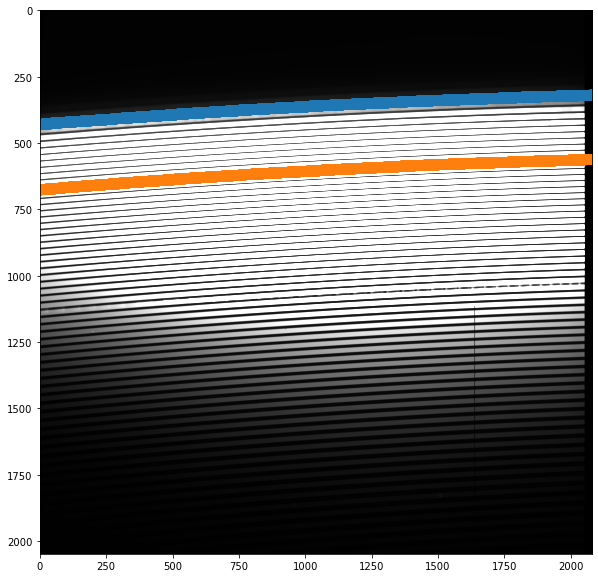

In [123]:

import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib

def fits_to_img(files):
    headers, datas, objs, dates, exps = np.empty(len(files), dtype=object), np.empty(len(files), dtype=object), \
                               np.empty(len(files), dtype=object), np.empty(len(files), dtype=object), \
                                        np.empty(len(files), dtype=object)
    for idx, file in enumerate(files):
        hdu_list = fits.open(file, memmap=True)
        data = hdu_list[0].data
        head = hdu_list[0].header
        obj = head['OBJECT']
        date = head['DATE-OBS'][:10]
        exp = head['EXPTIME']
        headers[idx] = head
        datas[idx] = np.array(data)
        objs[idx] = obj
        dates[idx] = date
        exps[idx] = exp

    return headers, datas, objs, dates, exps

def make_bias(data):
    stack = np.stack(data)
    med = np.median(stack, axis=0) #take median along shortest axis
    return med

def make_flat(data, exps, bias_frame):
    data_stack = np.stack(data)
    exp_box = []
    for exp in exps:
        exp_box.append(np.repeat(exp, bias_frame.shape[0]*bias_frame.shape[1]).reshape(bias_frame.shape[0],bias_frame.shape[1]))
    exp_box = np.array(exp_box)
    bias_subbed = data_stack - bias_frame
    div_exp = bias_subbed/exp_box #divide by exposure time
    med = np.median(div_exp, axis=0)
    normed = med/np.max(med)
    return med

def tophat(sig):
    topht = np.repeat(np.min(sig), len(sig))
    topht[sig > np.max(sig) / 2] = np.max(sig)
    return topht

bias_files = glob.glob("/Users/cm62383/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/Bias*.fits")
flat_files = glob.glob("/Users/cm62383/Box/GalArchLab/Data/Obs/HVS_obs/UT190401/Flat*.fits")

bias_headers, bias_data, bias_objs, bias_dates, bias_exps = fits_to_img(bias_files)
flat_headers, flat_data, flat_objs, flat_dates, flat_exps = fits_to_img(flat_files)

bias_frame = make_bias(bias_data)
flat_frame = make_flat(flat_data, flat_exps, bias_frame)

xx, yy = np.meshgrid(np.arange(0,flat_frame.shape[1]), np.arange(0,flat_frame.shape[0]))

template = tophat(flat_frame[440:468, 0])
#find and stores centers of each order
order_centers = []
columns = []
for i in range(21):
    pix_column = 100*i
    flat_slice = flat_frame[:, pix_column]
    #template = tophat(flat_slice[440:468])
    corr = signal.correlate(flat_slice, template, mode='same')
    peaks, properties = signal.find_peaks(corr, distance=13, prominence=(5e6, 1e20))
    if i == 0:
        peaks = peaks[1:]
        num_of_ords = len(peaks)
    order_centers.append(peaks[:num_of_ords])
    columns.append(pix_column)

pix_column = 2046
flat_slice = flat_frame[:, pix_column]
corr = signal.correlate(flat_slice, template, mode='same')
peaks, properties = signal.find_peaks(corr, distance=13, prominence=(5e6, 1e20))
troughs, props = signal.find_peaks(-flat_slice, distance=13, prominence=(5e2, 1e20))
order_centers.append(peaks[:num_of_ords])
columns.append(pix_column)
troughs = np.append(np.arange(0,306, 1),troughs)
scat_light = np.interp(np.arange(0,len(flat_slice), 1), troughs, flat_slice[troughs])

# plt.figure()
# plt.plot(flat_slice, color='gray')
# plt.plot(scat_light)
# plt.plot(peaks, flat_slice[peaks], "x", color="blue")
# plt.plot(troughs, flat_slice[troughs], "x", color="red")
# plt.show()
#
# plt.figure()
# plt.plot(flat_slice - scat_light, color='gray')
# plt.plot(peaks, flat_slice[peaks] - scat_light[peaks], "x", color="blue")
# plt.plot(troughs, flat_slice[troughs] - scat_light[troughs], "x", color="red")
# plt.show()


order_centers = np.array(order_centers).T
columns = np.array(columns)
column_grid = np.tile(columns, order_centers.shape[0]).reshape(order_centers.shape)

norm = matplotlib.colors.Normalize(vmin=np.min(flat_frame), vmax=np.max(flat_frame)/3)

orders = []
for i in range(column_grid.shape[0]):
    p = np.polynomial.Chebyshev.fit(column_grid[i], order_centers[i], 9)
    order = np.where((yy<p(xx[i])+10) & (yy>p(xx[i])-8))
    orders.append(order)

plt.figure(figsize=(10,10))
plt.imshow(flat_frame, cmap='gray', norm=norm)
plt.scatter(column_grid[0], order_centers[0], marker='.', s=5, color='red')
plt.scatter(xx[orders[0]], yy[orders[0]])
plt.scatter(xx[orders[10]], yy[orders[10]])
plt.show()

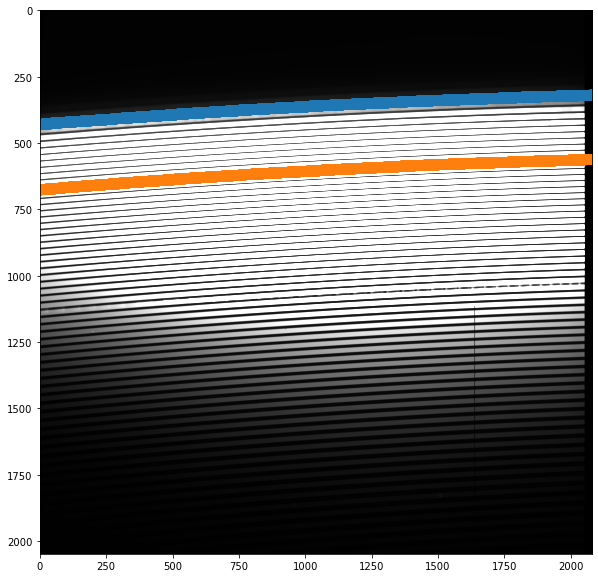

In [79]:
column_grid.shape

(55, 22)

In [56]:
yy.shape

(2048, 2080)